## ESE 527 Project  TMDB Box Office Prediction

Jiayi Zhou,Ruiying Wang

In [37]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

## Data Preprocessing:

Load the train and test dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [5]:
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [6]:
train.shape

(3000, 23)

In [7]:
test.shape

(4398, 22)

Draw the graph to show top 20 movies at revenue and their corresponding runtime and budget

In [8]:
train[['id','title','runtime', 'budget', 'revenue']].sort_values(['revenue'],ascending=False).head(20).style.background_gradient(subset=['revenue','runtime','budget'], cmap='PuBu')

,id,title,runtime,budget,revenue
1126,1127,The Avengers,143.000000,220000000,1519557910
1761,1762,Furious 7,137.000000,190000000,1506249360
2770,2771,Avengers: Age of Ultron,141.000000,280000000,1405403694
684,685,Beauty and the Beast,129.000000,160000000,1262886337
2322,2323,Transformers: Dark of the Moon,154.000000,195000000,1123746996
906,907,The Dark Knight Rises,165.000000,250000000,1084939099
2135,2136,Pirates of the Caribbean: On Stranger Tides,136.000000,380000000,1045713802
2562,2563,Finding Dory,97.000000,200000000,1028570889
881,882,Alice in Wonderland,108.000000,200000000,1025491110
734,735,Zootopia,108.000000,150000000,1023784195


Analysis each column and judge which column can influence the revenue.

-Belongs To Collection-

In [9]:
text_cols = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords']

def text_to_dict(df):
    for col in text_cols:
        df[col] = df[col].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df


train = text_to_dict(train)

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


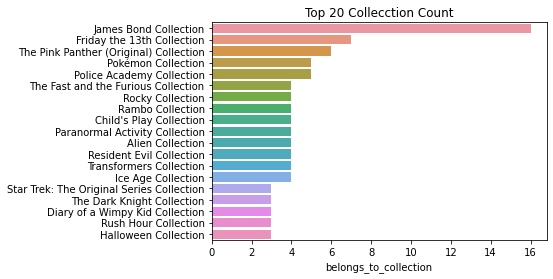

In [10]:
c = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0).value_counts()[1:20]
sns.barplot(c,c.index)
plt.title('Top 20 Collecction Count')
plt.show()

-Budget-

Since we found some value in budget is 0 which has no meaning to our dataset or they might be the missing value, we fill out these 0 value with the mean of budget.

In [11]:
mean=train['budget'].mean()
train['budget']=np.where(train['budget']==0,mean,train['budget'])
train['budget'].min()

1.0

-Runtime-

In [12]:
mean_runtime=train['runtime'].mean()
train['runtime']=np.where((train['runtime']==0)|(train['runtime'].isnull().values==True),mean_runtime,train['runtime'])

-Genres-

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


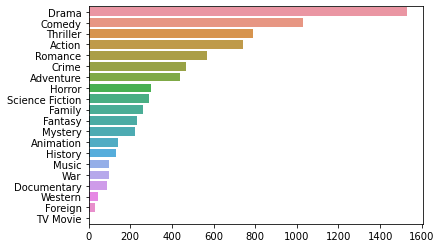

In [13]:
g = train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
g_count = Counter([i for j in g for i in j]).most_common()
sns.barplot([val[1] for val in g_count],[val[0] for val in g_count])
plt.show()

-Spoken Language & Original Language-

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26222 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotli

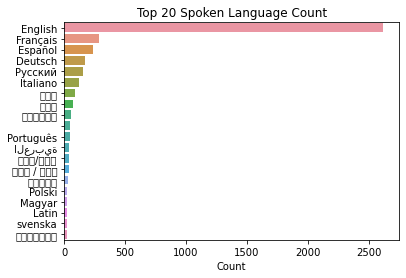

In [14]:
l = train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
l_count = Counter([i for j in l for i in j]).most_common(20)
sns.barplot([val[1] for val in l_count],[val[0] for val in l_count])
plt.xlabel('Count')
plt.title('Top 20 Spoken Language Count')
plt.show()

In [15]:
train['original_language'].value_counts()[:10]

en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
Name: original_language, dtype: int64

-Popularity-

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'popularity vs revenue')

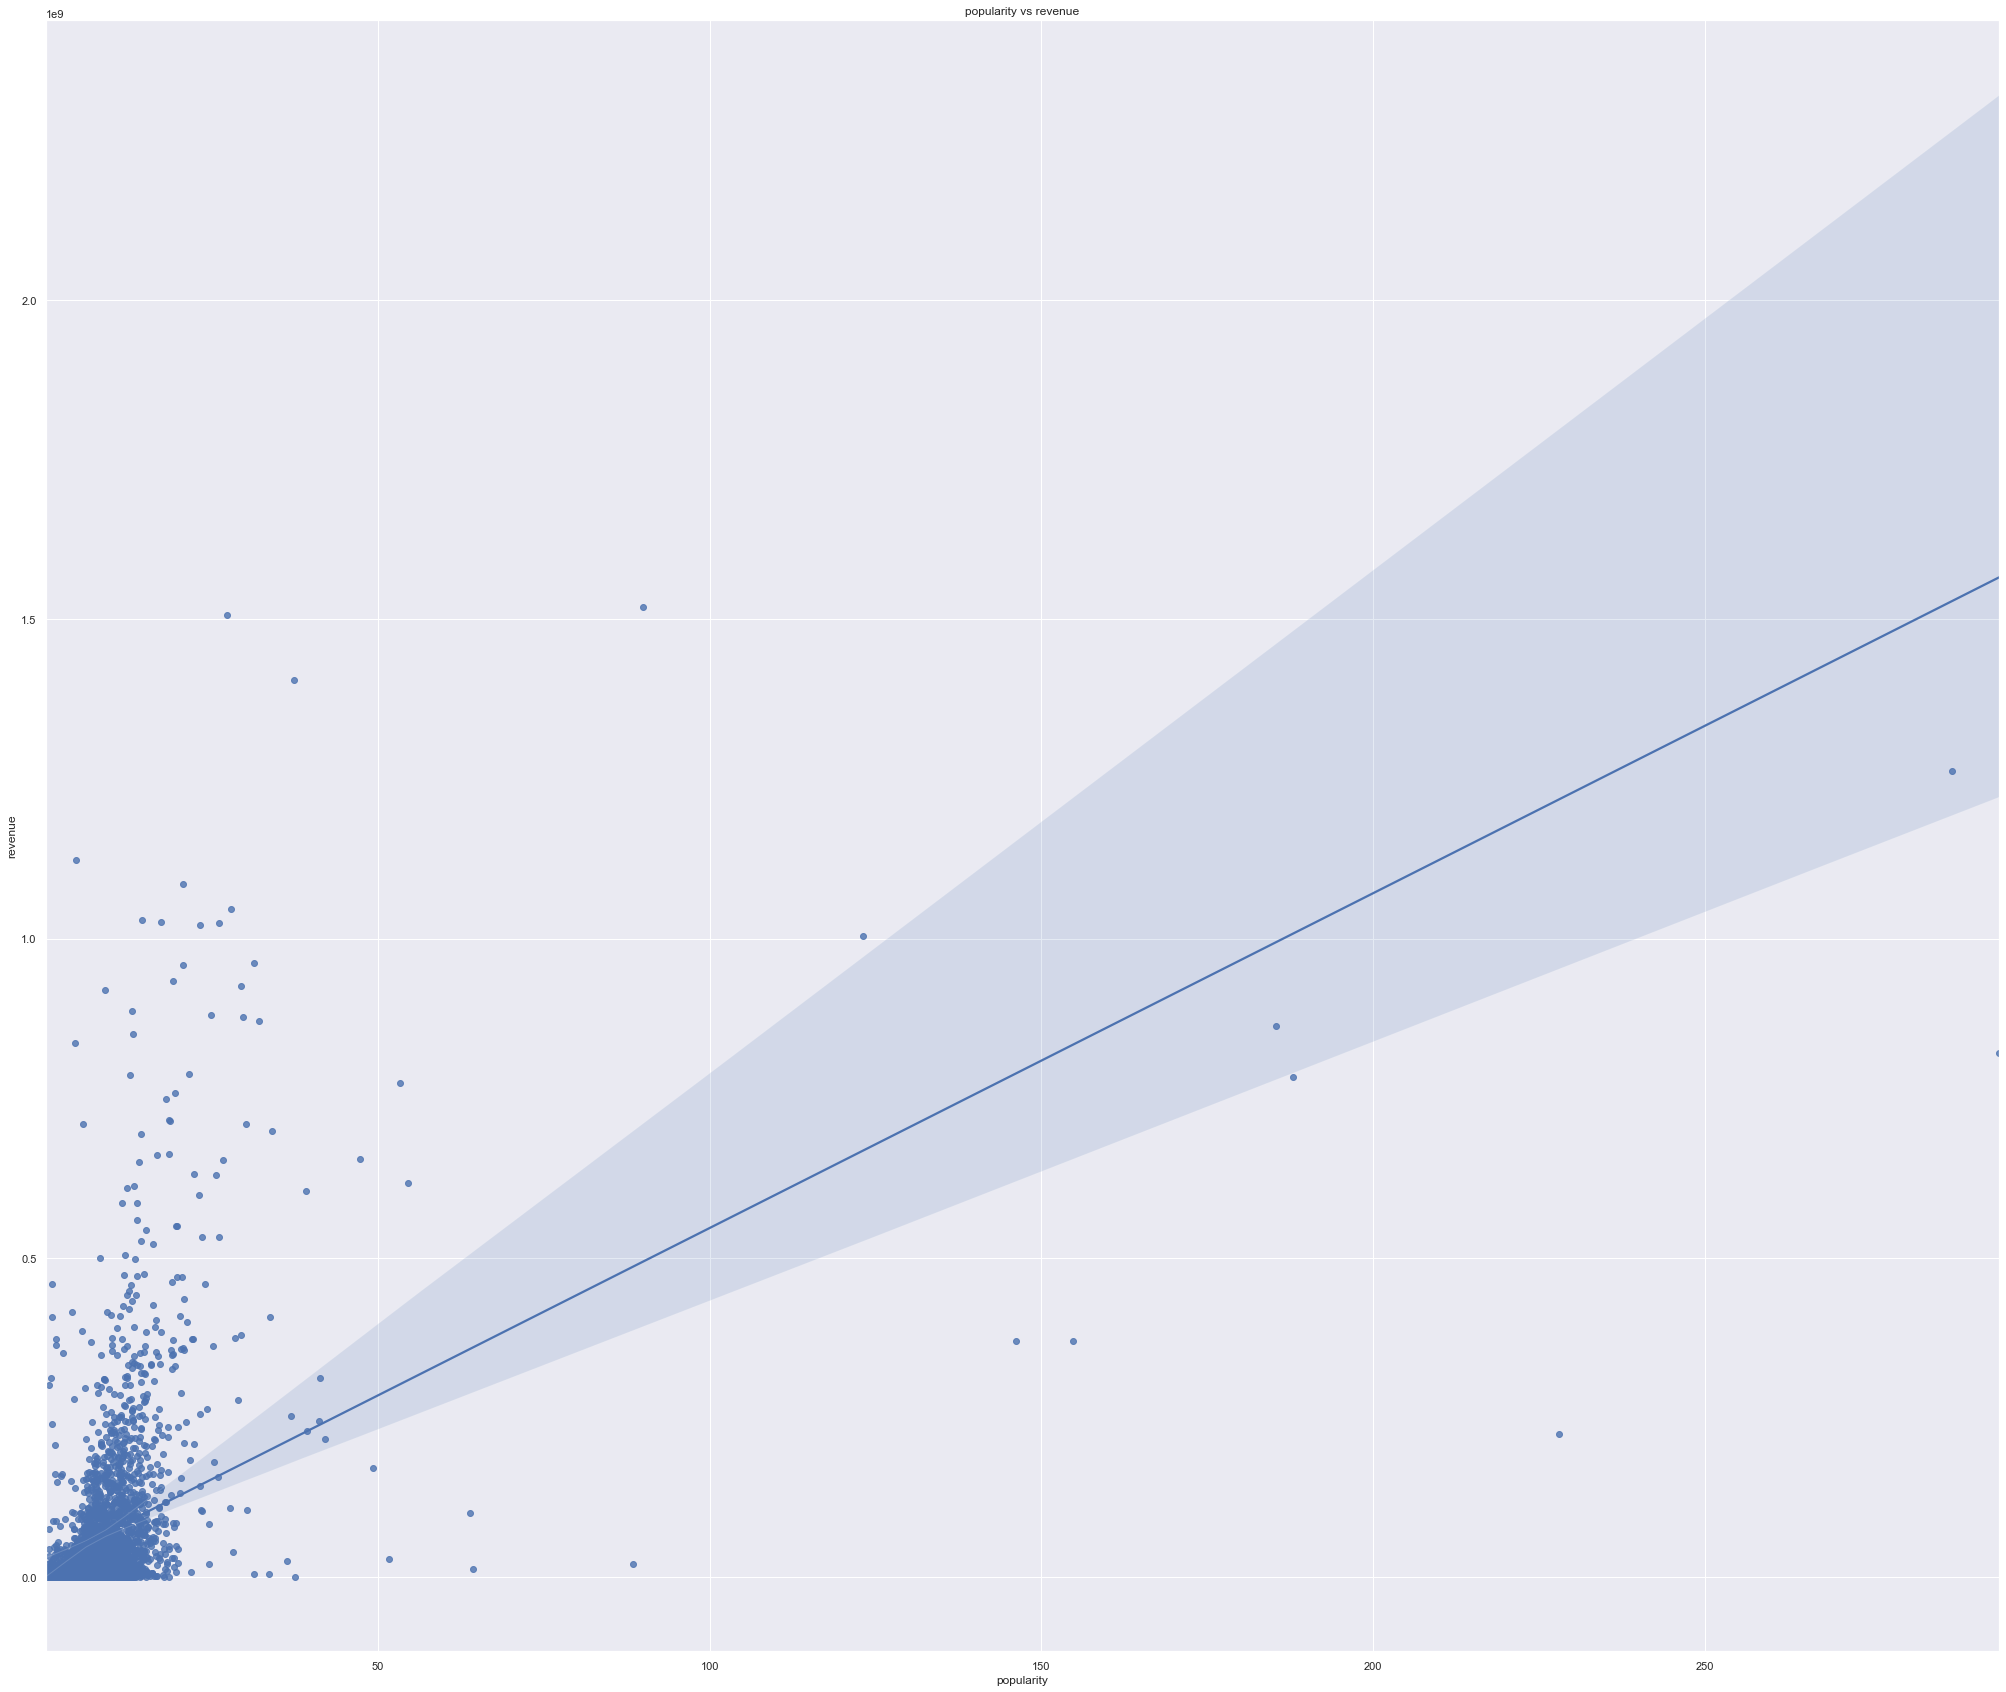

In [16]:
#popularity vs revenue
sns.set()
x=train['popularity']
y=train['revenue']
plt.figure(figsize=(35,30))
sns.regplot(x,y)
plt.xlabel('popularity')
plt.ylabel('revenue')
plt.title( 'popularity vs revenue')

-Homepage-

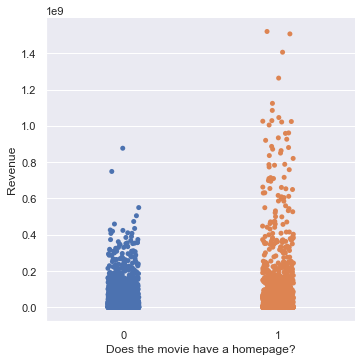

In [17]:
train['has_homepage'] = (1 - train.homepage.isna())
sns.catplot(x='has_homepage', y = 'revenue', data = train)
plt.xlabel('Does the movie have a homepage?')
plt.ylabel('Revenue')
plt.show()

In [18]:
x=np.where(train['homepage'].isnull().values==True)
len_null=len(x[0])
re=0
for i in x[0]:
    re=re+train['revenue'][i]
re_nh=re/len_null
re_h=(sum(train['revenue'])-re)/(3000-len_null)
print("revenue-nonhomepage",re_nh)
print("revenue-homepage",re_h)

revenue-nonhomepage 42165846.42940604
revenue-homepage 120051698.8372093


-Status-

In [19]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

-Release Date-

In [20]:
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900
releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter

Text(0.5, 1.0, 'Movie Mean Revenue By Year')

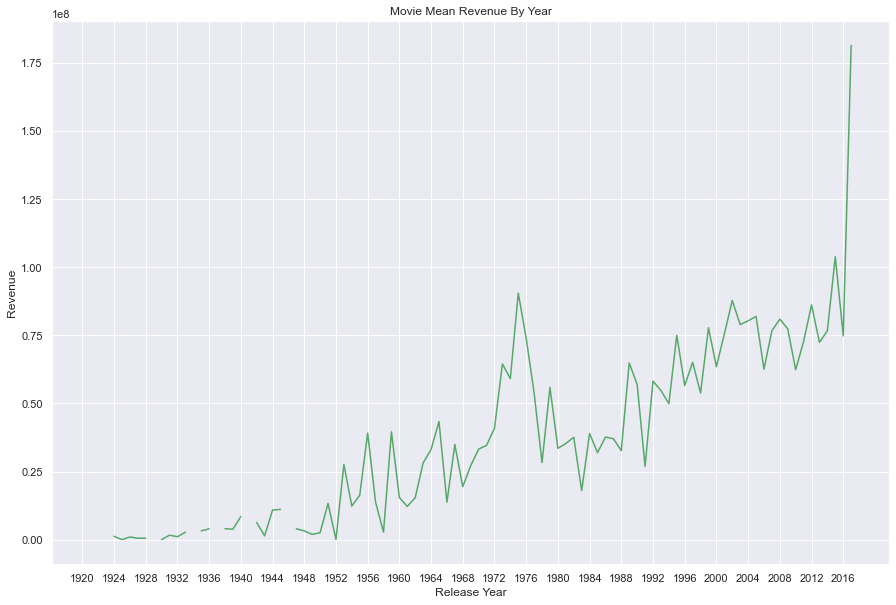

In [21]:
train['meanRevenueByYear'] = train.groupby("release_year")["revenue"].aggregate('mean')
train['meanRevenueByYear'].plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year")

-Tagline-

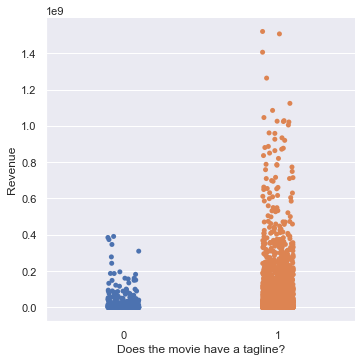

In [22]:
train['has_tagline'] = 1 - train['tagline'].isna()
sns.catplot(x="has_tagline", y="revenue", data=train)
plt.xlabel('Does the movie have a tagline?')
plt.ylabel('Revenue')
plt.show()

In [23]:
y= np.where(train['tagline'].isnull().values==True)
len_null=len(y[0])
re=0
for i in y[0]:
    re=re+train['revenue'][i]
re_nt=re/len_null
re_t=(sum(train['revenue'])-re)/(3000-len_null)
print("revenue-nontag",re_nt)
print("revenue-tag",re_t)

revenue-nontag 16966242.201005027
revenue-tag 79088101.98585102


-Production Countries-

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


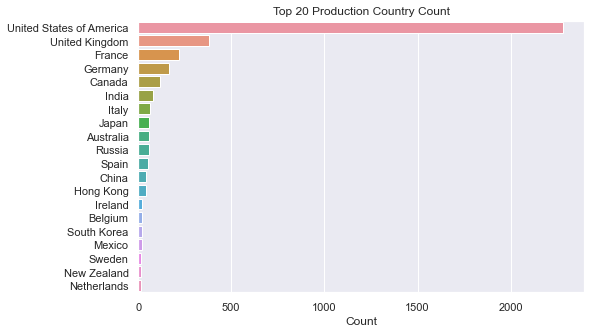

In [24]:
# Show which country produced most movies
countries_per = train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
countries_count = Counter([i for j in countries_per for i in j]).most_common(20)
fig = plt.figure(figsize=(8, 5))
sns.barplot([val[1] for val in countries_count],[val[0] for val in countries_count])
plt.xlabel('Count')
plt.title('Top 20 Production Country Count')
plt.show()

Use the heatmap to check the correlation of numerical variable.

<AxesSubplot:>

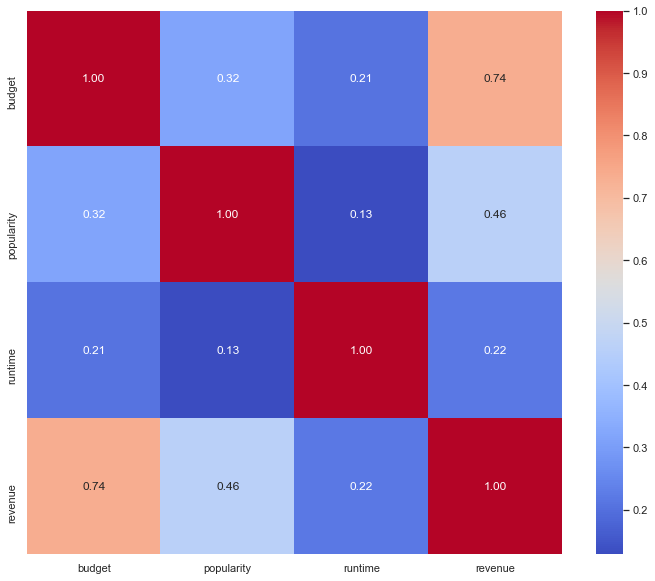

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(train[['budget','popularity','runtime','revenue']].corr(),annot=True, cmap='coolwarm',fmt='.2f')

In [26]:
#01encode
selected=train[["budget","popularity","runtime","homepage","tagline","revenue"]]
selected.loc[:,'homepage']=np.where(selected['homepage'].isnull().values==True,0,1)
selected.loc[:,'tagline']=np.where(selected['tagline'].isnull().values==True,0,1)
selected.isna().sum()

E:\anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


budget        0
popularity    0
runtime       0
homepage      0
tagline       0
revenue       0
dtype: int64

In [27]:
#test-train split
X=selected.loc[:,"budget":"tagline"]
y=selected.loc[:,"revenue"]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=112)
X_train

,budget,popularity,runtime,homepage,tagline
2686,22531334.11,0.158207,88.0,0,0
1713,22531334.11,11.485473,115.0,0,1
1236,60000000.00,8.810961,127.0,0,1
1990,5000000.00,6.199806,88.0,0,1
2954,60000000.00,10.411608,103.0,0,1
...,...,...,...,...,...
1221,22531334.11,5.634675,107.0,0,1
1012,17000000.00,11.035950,112.0,1,1
2369,70000000.00,7.739633,134.0,1,1
232,22531334.11,3.741330,93.0,0,0


## Model

In [43]:
#z-score normalization
trainX_mean=X_train.mean(axis=0)
trainX_var=X_train.std(axis=0)
trainY_mean=y_train.mean(axis=0)
trainY_var=y_train.std(axis=0)
train_normed_X=(X_train-trainX_mean)/trainX_var
test_normed_X=(X_test-trainX_mean)/trainX_var
train_normed_y=(y_train-trainY_mean)/trainY_var
test_normed_y=(y_test-trainY_mean)/trainY_var
test_normed_y

2867   -0.499325
105    -0.382043
876    -0.187989
2669    2.110821
2103    0.304092
          ...   
1586    1.250386
439    -0.504726
653    -0.506140
2400   -0.501681
1112   -0.046658
Name: revenue, Length: 900, dtype: float64

0.6182391976319074 91


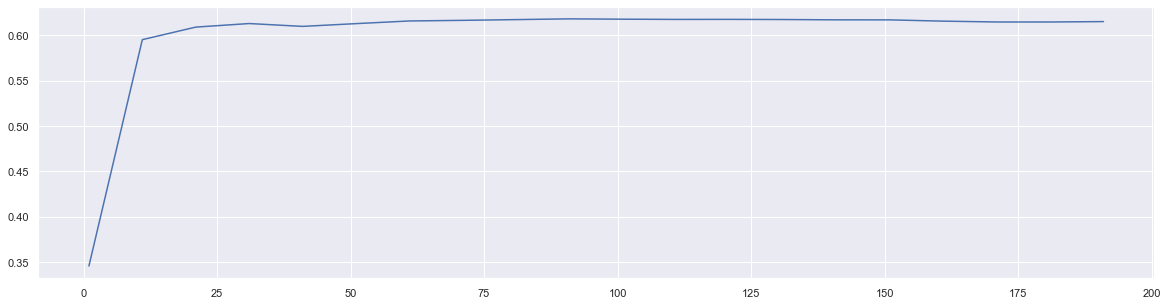

In [29]:
#Random Forest
scorel = []
for i in range(0,200,10):
    rfc = RandomForestRegressor(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,train_normed_X,train_normed_y,cv=10).mean()
    scorel.append(score)

print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

In [30]:
forest = RandomForestRegressor()

parameters = {'max_depth':np.arange(1,30,1),
              'n_estimators':np.arange(12,25,1)}
cv_rfr = GridSearchCV(forest,parameters)
cv_rfr.fit(train_normed_X,train_normed_y)
print(cv_rfr.best_params_)


{'max_depth': 5, 'n_estimators': 24}


In [33]:
forest = RandomForestRegressor(n_estimators=24,max_depth=5)
forest.fit(train_normed_X,train_normed_y)
y_pred = forest.predict(test_normed_X)
print("mean_squared_error:", mean_squared_error(test_normed_y, y_pred))
print("r2 score:", r2_score(test_normed_y, y_pred))


mean_squared_error: 0.4325246862264541
r2 score: 0.6604480765625425


budget        0.697371
popularity    0.225782
runtime       0.066415
homepage      0.010354
tagline       0.000077
dtype: float64

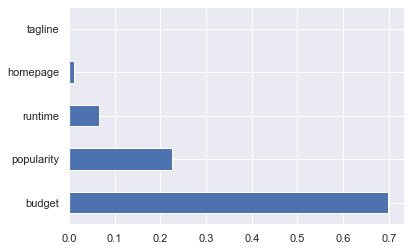

In [48]:
#feature importance
feat_importances = pd.Series(forest.feature_importances_, index = train_normed_X.columns)
feat_importances.plot(kind='barh')
feat_importances

0.6175830154197396 21


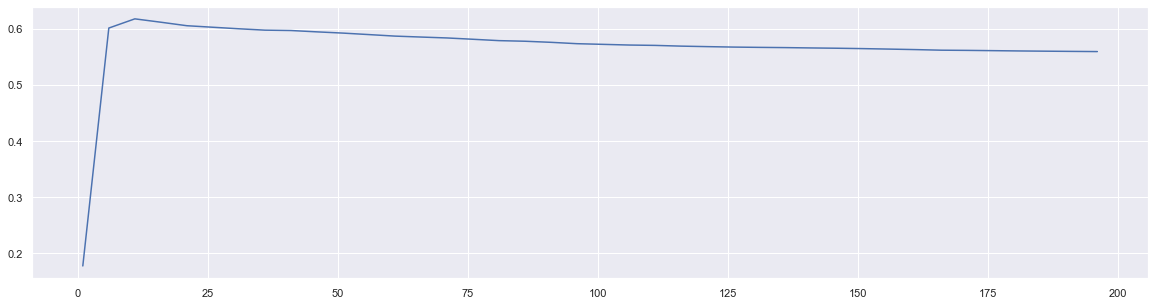

In [38]:
# XGbooster

xg = XGBRegressor()
score2 = []
for i in range(0,200,5):
    xg = XGBRegressor(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(xg,train_normed_X,train_normed_y,cv=10).mean()
    score2.append(score)

print(max(score2),(score2.index(max(score2))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,5),score2)
plt.show()

In [39]:
parameters = {'max_depth':np.arange(1,30,1),
              'n_estimators':np.arange(8,25,1)}
cv_xg = GridSearchCV(xg,parameters)
cv_xg.fit(train_normed_X,train_normed_y)
print(cv_xg.best_params_)

{'max_depth': 4, 'n_estimators': 10}


In [46]:
reg = XGBRegressor(
    n_estimators=10,
    max_depth=4)

reg.fit(train_normed_X, train_normed_y)
y_pred = reg.predict(test_normed_X)

print("mean_squared_error:", mean_squared_error(test_normed_y, y_pred))
print("r2 score:", r2_score(test_normed_y, y_pred))

mean_squared_error: 0.44678989770554783
r2 score: 0.6492492244502439


<AxesSubplot:>

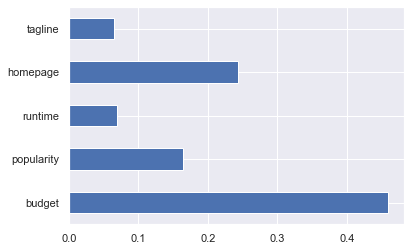

In [47]:
X_train = pd.DataFrame(train_normed_X, columns = X.columns)
feat_importances = pd.Series(xgb_model.feature_importances_, index = X_train.columns)
feat_importances.plot(kind='barh')